## HW3: Decision Tree, Random Forest, and Adaboost
In hw3, you need to implement decision tree, random forest and adaboost by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling sklearn.tree.DecisionTreeClassifier

In [1]:
# !pip install sklearn

## Load data

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from collections import Counter
import time

In [3]:
data = load_breast_cancer()
feature_names = data['feature_names']
print(feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [4]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv("y_test.csv")

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from the course sludes on E3

In [5]:
def gini(sequence):
    num_of_data = len(sequence)
    counts = np.bincount(sequence)
    probs = counts[np.nonzero(counts)] / num_of_data
    return 1 - np.sum(np.square(probs))


def entropy(sequence):
    num_of_data = len(sequence)
    counts = np.bincount(sequence)
    probs = counts[np.nonzero(counts)] / num_of_data
    num_of_classes = len(probs)
    if(num_of_classes <= 1):
        return 0
    return - np.sum(probs * np.log2(probs))

In [6]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [7]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [8]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the test data. You should implement two arguments for the Decision Tree algorithm
1. **Criterion**: The function to measure the quality of a split. Your model should support “gini” for the Gini impurity and “entropy” for the information gain. 
2. **Max_depth**: The maximum depth of the tree. If Max_depth=None, then nodes are expanded until all leaves are pure. Max_depth=1 equals to split data once


In [9]:
class Node:
    # split_feature & split_value are used for splitting the DecisionTree
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.split_feature = 0
        self.split_value = 0
        self.left = None
        self.right = None

In [10]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        self.criterion = criterion
        self.max_depth = max_depth if max_depth is not None else 10000  # Set a large depth limit if max_depth=None
        self.bestFeatureList = []

    def bestSplit(self, X, y):
        """
        Given input data X and target labels y, find the best split for a decision tree.
        """
        best_criterion = 1.0
        best_feature = None
        best_value = -1

        if len(y) <= 1:  # Need at least two elements to split
            return best_feature, best_value

        for feature in X.columns:
            # print('Current calculating feature:', feature)
            sorted_X = X.sort_values(by=[feature])  # a new DataFrame sorted by current feature

            for k in range(1, X.shape[0]):
                # Split the current feature DataFrame to left and right parts
                # i.e.(1, n-1), (2, n-2), ..., (n-1, 1)
                left_values = sorted_X[feature].iloc[:k]
                right_values = sorted_X[feature].iloc[k:]

                n_left = len(left_values)
                n_right = len(right_values)

                # Get the ground truth(y_train) using ID
                left_gt, right_gt = [], []
                left_gt = [y.at[ID, '0'] for ID in left_values.index]
                right_gt = [y.at[ID, '0'] for ID in right_values.index]

                # Calculate left & right criterion
                if(self.criterion == 'entropy'):
                    left_criterion = entropy(left_gt)
                    right_criterion = entropy(right_gt)
                else:  # criterion == 'gini'
                    left_criterion = gini(left_gt)
                    right_criterion = gini(right_gt)

                # Calculate the weighted average of criterion
                left_weight = n_left / X.shape[0]
                right_weight = n_right / X.shape[0]
                weighted_criterion = (left_weight * left_criterion) + (right_weight * right_criterion)

                if(weighted_criterion < best_criterion):
                    best_criterion = weighted_criterion
                    best_feature = feature
                    best_value = (sorted_X[best_feature].iat[k-1] + sorted_X[best_feature].iat[k]) / 2

        self.bestFeatureList.append(best_feature)
        return best_feature, best_value

    def buildTree(self, X, y, depth=0):
        # Predecting which class that current node belongs to
        y_array = y.to_numpy()[:, 0]  # Convert y DataFrame to a 1-D array
        num_of_data_per_class = np.bincount(y_array, minlength=2)
        predicted_class = np.argmax(num_of_data_per_class)

        node = Node(predicted_class=predicted_class)

        # Return if the ndoe is pure
        if(0 in num_of_data_per_class):
            return node

        if depth < self.max_depth:
            print('Current depth:', depth)
            split_feature, split_value = self.bestSplit(X, y)
            if split_feature is not None:
                node.split_feature = split_feature
                node.split_value = split_value

                # For each data in X,
                # filter out whether the data belongs to left sub-tree or right sub-tree
                left_filter = X[split_feature] <= split_value
                right_filter = X[split_feature] > split_value
                X_left = X[left_filter]
                X_right = X[right_filter]
                y_left = y[y.index.isin(X_left.index)]
                y_right = y[y.index.isin(X_right.index)]

                node.left = self.buildTree(X_left, y_left, depth + 1)
                node.right = self.buildTree(X_right, y_right, depth + 1)
        return node

    def fit(self, X, y):
        self.num_of_classes = 2  # 2 classes(0 or 1)
        self.num_of_features = X.shape[1]
        self.tree = self.buildTree(X, y)

    def predict(self, X):
        output = []
        for row in range(X.shape[0]):
            x = X.iloc[row]
            output.append(self.predict_each(x))
        return output

    def predict_each(self, x):
        node = self.tree
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        return node.predicted_class


In [11]:
clf_depth_None = DecisionTree(criterion='gini', max_depth=None)
clf_depth_None.fit(x_train, y_train)
y_pred_None = clf_depth_None.predict(x_test)
accuracy_score(y_test, y_pred_None)

Current depth: 0
Current depth: 1
Current depth: 2
Current depth: 3
Current depth: 4
Current depth: 3
Current depth: 2
Current depth: 3
Current depth: 4
Current depth: 4
Current depth: 3
Current depth: 1
Current depth: 2
Current depth: 2
Current depth: 3
Current depth: 4


0.916083916083916

### Question 2.1
Using Criterion=‘gini’, showing the accuracy score of test data by Max_depth=3 and Max_depth=10, respectively.


In [12]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [13]:
print('start building clf_depth3(gini, max_depth=3) model...')
start_time = time.time()

clf_depth3.fit(x_train, y_train)
y_pred_depth3 = clf_depth3.predict(x_test)

print("finished in %s seconds" % (time.time() - start_time))

start building clf_depth3(gini, max_depth=3) model...
Current depth: 0
Current depth: 1
Current depth: 2
Current depth: 2
Current depth: 1
Current depth: 2
Current depth: 2
finished in 34.09250450134277 seconds


In [14]:
print('start building clf_depth10(gini, max_depth=10) model...')
start_time = time.time()

clf_depth10.fit(x_train, y_train)
y_pred_depth10 = clf_depth10.predict(x_test)

print("finished in %s seconds" % (time.time() - start_time))

start building clf_depth10(gini, max_depth=10) model...
Current depth: 0
Current depth: 1
Current depth: 2
Current depth: 3
Current depth: 4
Current depth: 3
Current depth: 2
Current depth: 3
Current depth: 4
Current depth: 4
Current depth: 3
Current depth: 1
Current depth: 2
Current depth: 2
Current depth: 3
Current depth: 4
finished in 42.065643548965454 seconds


In [15]:
print('accuracy score of clf_depth3:', accuracy_score(y_test, y_pred_depth3))
print('accuracy score of clf_depth10:', accuracy_score(y_test, y_pred_depth10))

accuracy score of clf_depth3: 0.9230769230769231
accuracy score of clf_depth10: 0.916083916083916


In [16]:
# For comparison of accuracy
from sklearn import tree

clf_sklearn = tree.DecisionTreeClassifier()
clf_sklearn.fit(x_train, y_train)
y_pred_sklearn = clf_sklearn.predict(x_test)
print('accuracy score by sklearn:', accuracy_score(y_test, y_pred_sklearn))

accuracy score by sklearn: 0.9370629370629371


### Question 2.2
Using Max_depth=3, showing the accuracy score of test data by Criterion=‘gini’ and Criterion=’entropy’, respectively.


In [17]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)

In [18]:
print('start building clf_gini(max_depth=3) model...')
start_time = time.time()

clf_gini.fit(x_train, y_train)
y_pred_gini = clf_gini.predict(x_test)

print("finished in %s seconds" % (time.time() - start_time))

start building clf_gini(max_depth=3) model...
Current depth: 0
Current depth: 1
Current depth: 2
Current depth: 2
Current depth: 1
Current depth: 2
Current depth: 2
finished in 34.126285552978516 seconds


In [19]:
print('start building clf_entropy(max_depth=3) model...')
start_time = time.time()

clf_entropy.fit(x_train, y_train)
y_pred_entropy = clf_entropy.predict(x_test)

print("finished in %s seconds" % (time.time() - start_time))

start building clf_entropy(max_depth=3) model...
Current depth: 0
Current depth: 1
Current depth: 2
Current depth: 2
Current depth: 1
Current depth: 2
finished in 31.755241870880127 seconds


In [20]:
print('accuracy score of clf_gini:', accuracy_score(y_test, y_pred_gini))
print('accuracy score of clf_entropy:', accuracy_score(y_test, y_pred_entropy))

accuracy score of clf_gini: 0.9230769230769231
accuracy score of clf_entropy: 0.9230769230769231


- Note: All of your accuracy scores should over 0.9
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the feature counts for building tree without normalize the importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [21]:
# Calculate the occurrence of best_feature in 'clf_depth10' model
counts = Counter(clf_depth10.bestFeatureList)
counts = counts.most_common()
print(counts)

[('worst texture', 3), ('mean texture', 3), ('mean radius', 2), ('worst radius', 1), ('worst concave points', 1), ('area error', 1), ('worst area', 1), ('mean perimeter', 1), ('mean concavity', 1), ('mean concave points', 1), ('worst concavity', 1)]


Text(0.5, 1.0, 'Feature counts of clf_depth10')

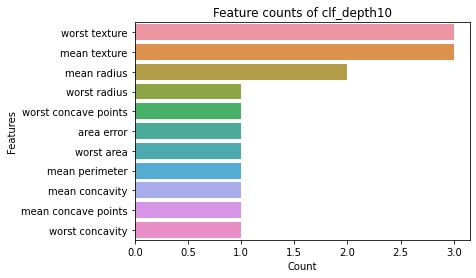

In [22]:
# Plot the feature counts of 'clf_depth10' model
import seaborn as sns

df = pd.DataFrame(counts, columns=['Features', 'Count'])
ax = sns.barplot(x='Count', y='Features', data=df)
ax.set_title('Feature counts of clf_depth10')

## Question 4
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **N_estimators**: The number of trees in the forest. 
2. **Max_features**: The number of random select features to consider when looking for the best split
3. **Bootstrap**: Whether bootstrap samples are used when building tree


In [16]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        

### Question 4.1
Using Criterion=‘gini’, Max_depth=None, Max_features=sqrt(n_features), showing the accuracy score of test data by n_estimators=10 and n_estimators=100, respectively.


In [17]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]))

### Question 4.2
Using Criterion=‘gini’, Max_depth=None, N_estimators=10, showing the accuracy score of test data by Max_features=sqrt(n_features) and Max_features=n_features, respectively.


In [18]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])

- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 